In [34]:
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\MARCELO\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [29]:
'''
EXTERNAL KERNEL
'''
google_colab = False
kaggle = False

'''
CUDA
'''
cuda = False

'''
DATA REPRESENTATION

1 => SINGLE READ | 2 => ADD FEATURES | 3 => WINDOW TO FEATURES
'''
DATA_REPRESENTATION = 2

'''
DOWNSAMPLE FACTOR

1 => 10hz *original rate* | 2 => 5Hz | 5 => 2Hz | 10 => 1hz
'''
DOWNSAMPLE_FACTOR = 5

'''
WINDOWS LENGHT

* needs divisor by datapoints target
* considering downsample factor = 5

1 => WINDOW DISABLED | 2 => 1 second | 4 => 2 seconds | 10 => 5 seconds | 20 => 10 seconds | 200 => 100 seconds *full flight*
'''
WINDOW_LENGHT =  1

'''
LIMITADOR

Quantity of samples in the execution of the tests.
'''
LIMITADOR = 10000

'''
LOSS FACTOR [0,1]

Ignores outliers in calculating the stats of losses in regenerated data.
'''
LOSS_FACTOR = 1

'''
TRAIN_SIZE [0,1]

Percentage of samples to be trained
'''
TRAIN_SIZE = 0.8

'''
OUTPUT_FILE_NAME

File with output results
'''
OUTPUT_FILE_NAME = 'output_knn_dr_' + str(DATA_REPRESENTATION) + '-ts_' + str(TRAIN_SIZE) + '-lf_' + str.replace(str(LOSS_FACTOR), '.', '') + '-limit_' + str(LIMITADOR) + '-wl_' + str(WINDOW_LENGHT) + '.txt'

'''
PATH_OUTPUTS

'''
PATH_OUTPUTS = './outputs/'

'''
PATH_DATASET

'''
PATH_DATASET = '../../dataset/original/'

'''
FLUSH FILE

If output results file is ON
'''
FLUSH_FILE = True

In [3]:
if google_colab:
    from google.colab import drive

    drive.mount('/content/drive')
    path = '/content/drive/My Drive/ACADÊMICO/MESTRADO/DISSERTAÇÃO/CHAPTERS/5 EXPERIMENTO/dataset/data_representation_1'
    dict_ds_original = {
        'data_ds3_normal_t1_original' : pd.read_csv(path+'/F16_DS3_normal_t1.csv', header=None),
        'data_ds3_normal_t2_original' : pd.read_csv(path+'/F16_DS3_normal_t2.csv', header=None),
        'data_ds3_fault1_original' : pd.read_csv(path+'/F16_DS3_fault1_leakage.csv', header=None),
        'data_ds3_fault2_original' : pd.read_csv(path+'/F16_DS3_fault2_viscousfriction.csv', header=None),
        'data_ds3_fault3_original' : pd.read_csv(path+'/F16_DS3_fault3_compressibility.csv', header=None),
        'data_ds3_fault4_original' : pd.read_csv(path+'/F16_DS3_fault4_fixedposition.csv', header=None),
    }
elif kaggle:
    !conda install -y gdown
    !gdown --id 1G88okIVmdcgLFlmd7rDRhHvHv98yK3UB
    !gdown --id 1fX3utfHMjwKTt7IW4D01bnm-hv88yzrJ
    !gdown --id 1yUG3R5zK2AIxtS9Q4Fk-udkKBZeYShgb
    !gdown --id 1OBRDtuqNEZ-3Z-q0helWh2xGiAxeLACH
    !gdown --id 17oDi60sWYsWHHxzj2aA9m6ARm8zQ81m_
    !gdown --id 1jKEK4s5sYJh8PHtpHeV8ABOsHjuB26RA
else:
    dict_ds_original = {
        'data_ds3_normal_t1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t1.csv', header=None),
        'data_ds3_normal_t2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t2.csv', header=None),
        'data_ds3_fault1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault1_leakage.csv', header=None),
        'data_ds3_fault2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault2_viscousfriction.csv', header=None),
        'data_ds3_fault3_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault3_compressibility.csv', header=None),
        'data_ds3_fault4_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault4_fixedposition.csv', header=None),
    }

In [4]:
dict_ds = dict_ds_original.copy()

if dict_ds['data_ds3_normal_t1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0 or dict_ds['data_ds3_fault1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0:
    raise Exception('Needs to be ?shape? divisor')

for n, dataset_name in enumerate(dict_ds):
    dataset = dict_ds[dataset_name].to_numpy()

    downsampled = dataset[::DOWNSAMPLE_FACTOR]

    x, y = downsampled.shape

    # resample
    dict_ds[dataset_name] = pd.DataFrame(downsampled.reshape((int(x/WINDOW_LENGHT),y*WINDOW_LENGHT)))


In [5]:
# ADD COLUMNS WITH DIFF PREVIOUS VALUES

if (DATA_REPRESENTATION == 2):
    frame_size = int(1000/DOWNSAMPLE_FACTOR)

    for n, dataset_name in enumerate(dict_ds):
        dataset = dict_ds[dataset_name].to_numpy()

        dimension = dataset.shape[1]
        samples = dataset.shape[0]

        # GENERATE NEW DIMENSIONS
        dataset = np.concatenate((dataset, np.zeros((samples,dimension))), axis=1)

        for f in np.arange(0,int(samples/frame_size)):
            # OBTAIN THE FRAME FLIGHT
            frame = dataset[f*frame_size:(f+1)*frame_size, 0:dimension]

            # CALCULATE DIFFERENCE
            chunk = np.diff(frame, axis=0)

            # DONT CALCULATE THE DIFFERENCE FOR EACH FIRST TIMESTEP
            chunk = np.insert(chunk, 0, frame[0, 0:dimension], axis=0)

            # UPDATE DATASET WITH NEW FRAME INTO NEW DIMENSIONS
            dataset[f*frame_size:(f+1)*frame_size,dimension:dimension*2] = chunk

        dict_ds[dataset_name] = pd.DataFrame(dataset)



In [6]:
ss = StandardScaler()

data_ds3_t1_normal = dict_ds['data_ds3_normal_t1_original']
data_ds3_t2_normal = dict_ds['data_ds3_normal_t2_original']
data_ds3_fault1 = dict_ds['data_ds3_fault1_original']
data_ds3_fault2 = dict_ds['data_ds3_fault2_original']
data_ds3_fault3 = dict_ds['data_ds3_fault3_original']
data_ds3_fault4 = dict_ds['data_ds3_fault4_original']

# fit values
ss.partial_fit(data_ds3_t1_normal)
ss.partial_fit(data_ds3_t2_normal)
ss.partial_fit(data_ds3_fault1)
ss.partial_fit(data_ds3_fault2)
ss.partial_fit(data_ds3_fault3)
ss.partial_fit(data_ds3_fault4)

# transform values
data_ds3_t1_normal = ss.transform(data_ds3_t1_normal)
data_ds3_t2_normal = ss.transform(data_ds3_t2_normal)
data_ds3_fault1 = ss.transform(data_ds3_fault1)
data_ds3_fault2 = ss.transform(data_ds3_fault2)
data_ds3_fault3 = ss.transform(data_ds3_fault3)
data_ds3_fault4 = ss.transform(data_ds3_fault4)

# append normal labels
data_ds3_t1_normal = np.append(data_ds3_t1_normal, np.zeros((data_ds3_t1_normal.shape[0],1)), axis = 1)
data_ds3_t2_normal = np.append(data_ds3_t2_normal, np.zeros((data_ds3_t2_normal.shape[0],1)), axis = 1)

# append fault labels
def generate_fault_label(dataset, fault_label):
    labels = np.array([[fault_label]]*dataset.shape[0])

    return labels

data_ds3_fault1 = np.append(data_ds3_fault1, generate_fault_label(data_ds3_fault1, 1), axis = 1)
data_ds3_fault2 = np.append(data_ds3_fault2, generate_fault_label(data_ds3_fault2, 2), axis = 1)
data_ds3_fault3 = np.append(data_ds3_fault3, generate_fault_label(data_ds3_fault3, 3), axis = 1)
data_ds3_fault4 = np.append(data_ds3_fault4, generate_fault_label(data_ds3_fault4, 4), axis = 1)

In [24]:
def verify_inliers(inliers):
    inliers_detected = 0
    for k, x in enumerate(inliers):
        if (x == 1):
            inliers_detected = inliers_detected+1

    print(inliers_detected/len(inliers)*100, file=log)

def verify_outliers(outliers):
    outliers_detected = 0
    for k, x in enumerate(outliers):
        if (x == -1):
            outliers_detected = outliers_detected+1

    print(outliers_detected/len(outliers)*100, file=log)

knn_p = {
    'a': ['gini'],
    'b': ['best'],
    'c': ['minkowski']
}

lof = []
for a in knn_p['a']:
    for b in knn_p['b']:
        for c in knn_p['c']:
            lof.append(KNeighborsClassifier(n_neighbors=5, metric='cosine', weights='distance'))

In [22]:
faults = np.concatenate((data_ds3_t1_normal[:100000], data_ds3_t2_normal[:100000], data_ds3_fault1[:100000], data_ds3_fault2[:100000], data_ds3_fault3[:100000], data_ds3_fault4[:100000]))

X_train, X_test, y_train, y_test = train_test_split(faults[:, :-1], faults[:, -1], test_size=1-TRAIN_SIZE, random_state=42, shuffle=True)

In [27]:
'''p = PCA(.95)
p_faults = p.fit_transform(X_train)'''

clfs = []

for clf in lof:
    print('.', end='')
    clfs.append(clf.fit(X_train, y_train))

.

In [30]:
log = None
if FLUSH_FILE:
    log = open(PATH_OUTPUTS+OUTPUT_FILE_NAME, "a", buffering=1)

for k, clf in enumerate(clfs):
    print(clf, file=log)

    print(confusion_matrix(y_test[:LIMITADOR], clf.predict(X_test[:LIMITADOR]), normalize='true'), file=log)

if FLUSH_FILE:
    log.close()

In [46]:
y = y_test[:LIMITADOR]
y_hat = clf.predict(X_test[:LIMITADOR])

data = confusion_matrix(y, y_hat, normalize='true')

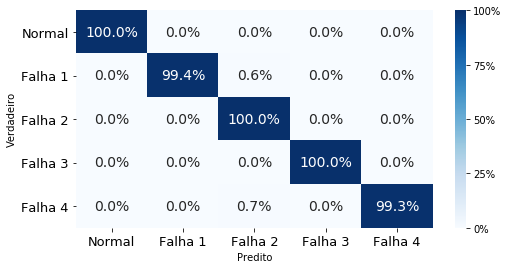

In [53]:

fontsize_xylabel = 13
fontsize_tick = 14
'''tn, fp, fn, tp = data.ravel()
print('Balanced Accuracy: ', balanced_accuracy_score(y_true, y_pred))
print('Precision: ', precision_score(y_true, y_pred))
print('Recall: ', recall_score(y_true, y_pred))
print('Specificity: ', (tn / (tn+fp)))
print(classification_report(y_true, y_pred))'''

inputed = ['Normal', 'Anomalia']
predicted = ['Normal', 'Anomalia']

df = pd.DataFrame(np.array(data), index=['Normal','Falha 1','Falha 2','Falha 3','Falha 4'], columns=['Normal','Falha 1','Falha 2','Falha 3','Falha 4'])

fig, axs = plt.subplots(figsize=(8,4))
cm = sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', rasterized=True, annot_kws={"fontsize":fontsize_tick})
cm.set_xticklabels(cm.get_xticklabels(), rotation = 0, size=fontsize_xylabel)
cm.set_yticklabels(cm.get_yticklabels(), rotation = 0, size=fontsize_xylabel)

plt.xlabel('Predito')
plt.ylabel('Verdadeiro')

colorbar = cm.collections[0].colorbar
colorbar.set_ticks([0, .25, .5, .75, 1])
colorbar.set_ticklabels(['0%','25%', '50%', '75%', '100%'])

fig = cm.get_figure()
fig.savefig("../../charts/6_classifier_knn_heatmap.pdf", bbox_inches='tight')

In [45]:
data

array([[3324,    0,    0,    1,    0],
       [   0, 1671,   10,    0,    0],
       [   0,    0, 1709,    0,    0],
       [   0,    0,    0, 1639,    0],
       [   0,    0,   11,    0, 1635]], dtype=int64)